# Model Training

### Imports

In [17]:
!pip install sagemaker boto3 smdebug sagemaker-experiments

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [28]:
pip install --upgrade awscli boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 967.2 kB/s eta 0:00:0000:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.56
    Uninstalling botocore-1.19.56:
      Successfully uninstalled botocore-1.19.56
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.3.7
    Uninstalling s3transfer-0.3.7:
      Successfully u

In [2]:
import sagemaker
import boto3
import pandas as pd
from sagemaker import get_execution_role, KMeans, session
from sagemaker import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sagemaker import KMeans
from sklearn.metrics import silhouette_score
import time
import json
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
from sagemaker.model import Model
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import os
import tarfile

## Get Training Data From S3

In [3]:
# Load the train dataset from S3
train_df = pd.read_csv('s3://team6datasets/splitDatasets/train.csv')
print(train_df.head())

   CustomerID  Year_Birth  Purchase_Frequency  Age  Total_Spent_byCustomer  \
0          92        1995                 169   29                 3657.63   
1       10299        1954                 172   70                 1859.15   
2        3428        1973                 172   51                 3019.30   
3        4832        1943                 164   81                 2866.52   
4        5837        1964                 195   60                 4012.45   

   gender_Agender  gender_Bigender  gender_Female  gender_Genderfluid  \
0               0                0              0                   0   
1               0                0              1                   0   
2               0                0              0                   0   
3               0                0              1                   0   
4               0                0              0                   0   

   gender_Genderqueer  ...  SpendingCategory_High  SpendingCategory_Very High  \
0          

## Train KNN Model

### Feature Selection with SKLearn IPCA & SageMaker Built-In PCA

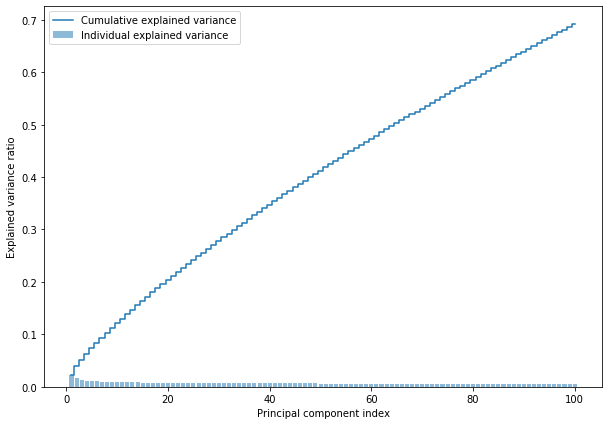

In [4]:
# Scaler
scaler = StandardScaler()

# Convert to float32 for memory efficiency
scaled_data = scaler.fit_transform(train_df.astype('float32'))

# Use IncrementalPCA
ipca = IncrementalPCA(n_components=100, batch_size=150)  # Adjust batch_size
ipca.fit(scaled_data)

# Plot the explained variance ratio
plt.figure(figsize=(10, 7))
plt.bar(range(1, ipca.n_components_ + 1), ipca.explained_variance_ratio_, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, ipca.n_components_ + 1), np.cumsum(ipca.explained_variance_ratio_), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [28]:
# Define PCA model
pca_estimator = PCA(role=get_execution_role(),
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    num_components=10,
                    sagemaker_session=sagemaker_session)

# Fit PCA model
pca_estimator.fit(pca_estimator.record_set(scaled_data))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pca-2024-03-30-22-09-47-786


2024-03-30 22:09:47 Starting - Starting the training job...
2024-03-30 22:10:11 Starting - Preparing the instances for trainingProfilerReport-1711836587: InProgress
...
2024-03-30 22:10:37 Downloading - Downloading input data...
2024-03-30 22:11:17 Downloading - Downloading the training image.........
2024-03-30 22:12:33 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[03/30/2024 22:12:48 INFO 140210834298688] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '

In [43]:
# # access PCA artifacts
# model_artifacts_s3_uri = pca_estimator.model_data
# print("Model artifacts saved at:", model_artifacts_s3_uri)

Model artifacts saved at: s3://sagemaker-us-east-1-851725438030/pca-2024-03-30-22-09-47-786/output/model.tar.gz


In [45]:
# # Create a S3 client
# s3 = boto3.client('s3')
# bucket_name = model_artifacts_s3_uri.split('/')[2]
# object_key = '/'.join(model_artifacts_s3_uri.split('/')[3:])

# # Download the model artifacts file
# s3.download_file(bucket_name, object_key, 'model.tar.gz')

# # Extract the model artifacts file
# with tarfile.open('model.tar.gz') as tar:
#     tar.extractall()
#     print("Extracted model artifacts in the current directory")

Extracted model artifacts in the current directory


In [ ]:
# import mxnet as mx

# data = mx.ndarray.load('model_algo-1')
# # MXNet NDArrays named 's' usually contain the singular values, which can be related to explained variance

In [ ]:
# # total variance ratios
# explained_variance_ratio = np.square(data['s'].asnumpy()) / np.sum(np.square(data['s'].asnumpy()))

# # Plotting the cumulative explained variance
# plt.figure(figsize=(10, 7))
# plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-', color='b')
# plt.title('Cumulative Explained Variance by Principal Component')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

### Set Up Experiment for KNN Model Training Trials

In [5]:
# set up experiment
experiment_name = f"KMeans-Clustering-Experiment-{int(time.time())}"
experiment_description = "Comparing 3 KMeans models with different hyperparameters."

experiment = Experiment.create(
    experiment_name=experiment_name,
    description=experiment_description,
    sagemaker_boto_client=boto3.client('sagemaker')
)

In [6]:
# define hyperparameters for 3 KNN models
hyperparameter_sets = [
    {'k': '5', 'init_method': 'random'},
    {'k': '10', 'init_method': 'random'},
    {'k': '15', 'init_method': 'random'}
]

### Run Experiment Trials for KNN Models

In [7]:
# create my own S3 bucket
s3 = boto3.client('s3')
s3.create_bucket(Bucket='team6experiments')

{'ResponseMetadata': {'RequestId': 'MSFC5XQHS90JZQ01',
  'HostId': '5Cb6shbfHOHg00xGqapoXiRofoKM107TO0vkxLErX6nqvCgrCLVgv6jk83JEPZvlmobG263Lvzo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '5Cb6shbfHOHg00xGqapoXiRofoKM107TO0vkxLErX6nqvCgrCLVgv6jk83JEPZvlmobG263Lvzo=',
   'x-amz-request-id': 'MSFC5XQHS90JZQ01',
   'date': 'Sun, 31 Mar 2024 21:59:20 GMT',
   'location': '/team6experiments',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/team6experiments'}

In [11]:
# Run trials
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name

for hyperparameters in hyperparameter_sets:
    # Create a trial
    trial_name = f"kmeans-trial-k-{hyperparameters['k']}-{int(time.time())}"
    trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=experiment.experiment_name,
        sagemaker_boto_client=boto3.client('sagemaker'),
    )
    
    # define output path
    output_path = f's3://team6experiments/{trial_name}/'
    
    # Create the KMeans estimator
    kmeans = KMeans(role=role,
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    k=int(hyperparameters['k']),
                    sagemaker_session=sagemaker_session,
                    output_path= output_path)

    # Fit the model
    kmeans.fit(kmeans.record_set(scaled_data), wait=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-31-22-05-02-255


2024-03-31 22:05:02 Starting - Starting the training job...
2024-03-31 22:05:26 Starting - Preparing the instances for trainingProfilerReport-1711922702: InProgress
...
2024-03-31 22:05:57 Downloading - Downloading input data......
2024-03-31 22:06:47 Downloading - Downloading the training image......
2024-03-31 22:07:58 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/31/2024 22:08:06 INFO 140354741135168] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-31-22-09-00-300


2024-03-31 22:09:00 Starting - Starting the training job...
2024-03-31 22:09:24 Starting - Preparing the instances for trainingProfilerReport-1711922940: InProgress
...
2024-03-31 22:09:51 Downloading - Downloading input data...
2024-03-31 22:10:31 Downloading - Downloading the training image.........
2024-03-31 22:11:51 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/31/2024 22:11:59 INFO 139683796514624] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-31-22-12-59-677


2024-03-31 22:12:59 Starting - Starting the training job...
2024-03-31 22:13:23 Starting - Preparing the instances for trainingProfilerReport-1711923179: InProgress
...
2024-03-31 22:13:54 Downloading - Downloading input data......
2024-03-31 22:14:43 Downloading - Downloading the training image......
2024-03-31 22:15:55 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/31/2024 22:16:07 INFO 139780067415872] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable

### Calculate Silhouette Scores for KNN Models

In [12]:
# define model artifacts and hyperparameters
model_artifacts = [
    {
        "model_data": "s3://team6experiments/kmeans-trial-k-5-1711914356/kmeans-2024-03-31-19-46-11-504/output/model.tar.gz", # need to get links to S3 artifacts first!
        "hyperparameters": {"k": 5}
    },
    {
        "model_data": "s3://team6experiments/kmeans-trial-k-10-1711914593/kmeans-2024-03-31-19-50-08-046/output/model.tar.gz", # need to get links to S3 artifacts first!
        "hyperparameters": {"k": 10}
    },
    {
        "model_data": "s3://team6experiments/kmeans-trial-k-15-1711914830/kmeans-2024-03-31-19-54-05-839/output/model.tar.gz", # need to get links to S3 artifacts first!
        "hyperparameters": {"k": 15}
    }
]

In [13]:
# automate deployment, prediction, and evaluation for KNN models
def deploy_predict_evaluate(model_data, hyperparameters):
    print(f"Deploying model with data: {model_data}")
    
    # Define model
    model = Model(
        model_data=model_data,
        image_uri=sagemaker.image_uris.retrieve('kmeans', region),
        role=role,
        sagemaker_session=sagemaker_session
    )
    
    # Attempt to deploy the model
    try:
        predictor = model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
        print("Model deployed successfully.")
    except Exception as e:
        print(f"An error occurred during model deployment: {e}")
        return None
    
    if predictor:
        # Set serializer and deserializer
        predictor.serializer = CSVSerializer()
        predictor.deserializer = JSONDeserializer()
        
        try:
            # Make predictions
            results = predictor.predict(scaled_data.tolist())
            cluster_labels = np.array([r['closest_cluster'] for r in results['predictions']])
            
            # Evaluate with Silhouette Score
            score = silhouette_score(scaled_data, cluster_labels)
            print(f"Silhouette Score for k={hyperparameters['k']}: {score}")
        except Exception as e:
            print(f"An error occurred during prediction or evaluation: {e}")
            score = None
        finally:
            # Clean up
            try:
                sagemaker.Session().delete_endpoint(predictor.endpoint_name)
                print("Endpoint deleted successfully.")
            except Exception as e:
                print(f"Failed to delete endpoint {predictor.endpoint_name}: {e}")
    else:
        print("Deployment failed. Predictor is None.")
        score = None
    
    return score

# Assuming 'model_artifacts' and 'scaled_data' are defined earlier in your code
silhouette_scores = [deploy_predict_evaluate(artifact['model_data'], artifact['hyperparameters']) for artifact in model_artifacts]

print("Silhouette scores:", silhouette_scores)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2024-03-31-22-18-30-407


Deploying model with data: s3://team6experiments/kmeans-trial-k-5-1711914356/kmeans-2024-03-31-19-46-11-504/output/model.tar.gz


INFO:sagemaker:Creating endpoint with name kmeans-2024-03-31-22-18-31-132


-----------------!

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2024-03-31-22-27-04-418


Model deployed successfully.
Deployment failed. Predictor is None.
Deploying model with data: s3://team6experiments/kmeans-trial-k-10-1711914593/kmeans-2024-03-31-19-50-08-046/output/model.tar.gz


INFO:sagemaker:Creating endpoint with name kmeans-2024-03-31-22-27-05-204


--------------------!

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2024-03-31-22-37-09-447


Model deployed successfully.
Deployment failed. Predictor is None.
Deploying model with data: s3://team6experiments/kmeans-trial-k-15-1711914830/kmeans-2024-03-31-19-54-05-839/output/model.tar.gz


INFO:sagemaker:Creating endpoint with name kmeans-2024-03-31-22-37-10-173


-------------------

KeyboardInterrupt: 

In [ ]:
# release end-point
sagemaker.Session().delete_endpoint(predictor.endpoint_name)